<a href="https://colab.research.google.com/github/g-sowmya/Frequency-Domain-Feature-Extraction-Using-FFT-for-MRI-Image-Classification/blob/main/tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gummadisowmya2002","key":"5fd448cb8d99b0dcfa9bc9d3ccce0c53"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip -d dataset/
all


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: dataset/brain_tumor_dataset/no/1 no.jpeg  
  inflating: dataset/brain_tumor_dataset/no/10 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/11 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/12 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/13 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/14 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/15 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/17 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/18 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/19 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/2 no.jpeg  
  inflating: dataset/brain_tumor_dataset/no/20 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/21 no.jpg  
  inflating: dataset/brain_tumor_dataset/no/22 no.jpg  
  inflating: dataset/brain_tumor

<function all(iterable, /)>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fftpack import fft2
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


In [ ]:
def load_images_from_folder(folder_path):
    images, labels = [], []
    for label in os.listdir(folder_path):
        class_path = os.path.join(folder_path, label)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                images.append(img)
                labels.append(label)
    return images, labels


In [ ]:
def extract_fft_features(image):
    eq_img = cv2.equalizeHist(image)
    fft = np.abs(fft2(eq_img))
    fft_shifted = np.fft.fftshift(fft)
    fft_log = np.log1p(fft_shifted)

    energy = np.sum(fft_log**2)
    ent = entropy(fft_log.flatten())
    dominant = np.mean(np.sort(fft_log.flatten())[-20:])

    return [energy, ent, dominant]


In [ ]:
images, labels = load_images_from_folder('dataset/brain_tumor_dataset')

features = [extract_fft_features(img) for img in images]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
models = {
    "SVM": SVC(kernel='rbf', C=1),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier()
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model



🔍 SVM Evaluation on TEST Set:
Accuracy: 0.5490196078431373
Precision: 0.5416666666666666
F1 Score: 0.6933333333333334
              precision    recall  f1-score   support

          no       0.67      0.08      0.15        24
         yes       0.54      0.96      0.69        27

    accuracy                           0.55        51
   macro avg       0.60      0.52      0.42        51
weighted avg       0.60      0.55      0.44        51



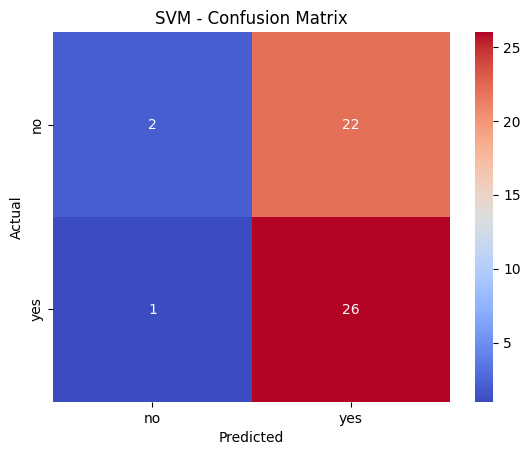


🔍 Random Forest Evaluation on TEST Set:
Accuracy: 0.5294117647058824
Precision: 0.5428571428571428
F1 Score: 0.6129032258064516
              precision    recall  f1-score   support

          no       0.50      0.33      0.40        24
         yes       0.54      0.70      0.61        27

    accuracy                           0.53        51
   macro avg       0.52      0.52      0.51        51
weighted avg       0.52      0.53      0.51        51



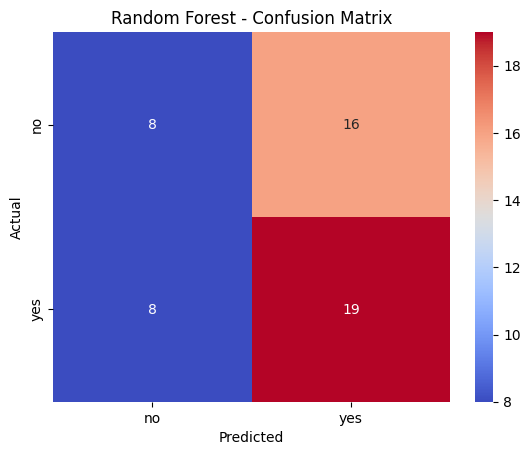


🔍 Gradient Boosting Evaluation on TEST Set:
Accuracy: 0.5882352941176471
Precision: 0.5882352941176471
F1 Score: 0.6557377049180327
              precision    recall  f1-score   support

          no       0.59      0.42      0.49        24
         yes       0.59      0.74      0.66        27

    accuracy                           0.59        51
   macro avg       0.59      0.58      0.57        51
weighted avg       0.59      0.59      0.58        51



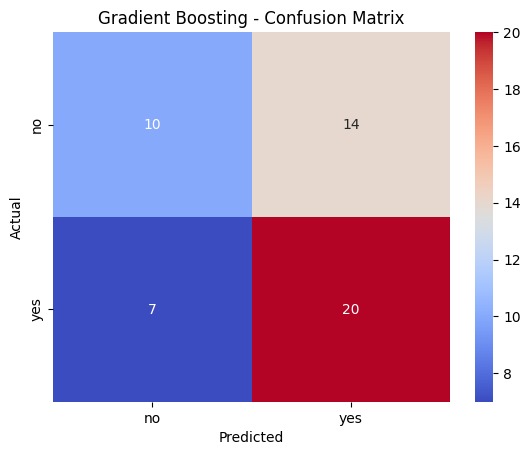

In [ ]:
for name, model in trained_models.items():
    print(f"\n🔍 {name} Evaluation on TEST Set:")
    y_pred = model.predict(X_test_scaled)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, pos_label='yes'))
    print("F1 Score:", f1_score(y_test, y_pred, pos_label='yes'))
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

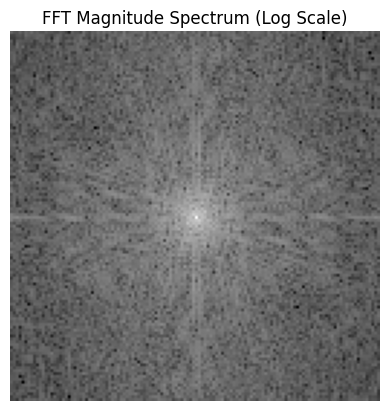

In [ ]:
sample_img = images[0]
eq = cv2.equalizeHist(sample_img)
fft_mag = np.abs(fft2(eq))
fft_shifted = np.fft.fftshift(fft_mag)
fft_log = np.log1p(fft_shifted)

plt.imshow(fft_log, cmap='gray')
plt.title("FFT Magnitude Spectrum (Log Scale)")
plt.axis("off")
plt.show()



📊 Model Comparison:

               Model  Accuracy  Precision    Recall  F1 Score
0                SVM  0.549020   0.541667  0.962963  0.693333
1      Random Forest  0.529412   0.542857  0.703704  0.612903
2  Gradient Boosting  0.588235   0.588235  0.740741  0.655738


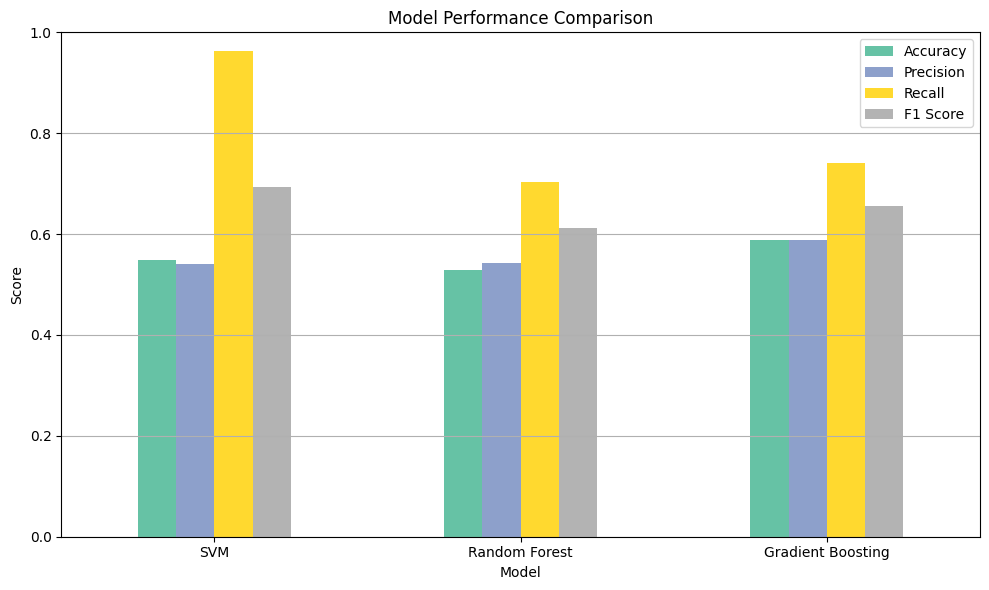

In [ ]:
from sklearn.metrics import recall_score

model_metrics = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label='yes')
    f1 = f1_score(y_test, y_pred, pos_label='yes')
    rec = recall_score(y_test, y_pred, pos_label='yes')

    model_metrics.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

import pandas as pd
df_metrics = pd.DataFrame(model_metrics)

print("\n📊 Model Comparison:\n")
print(df_metrics)

df_metrics.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(
    kind="bar", figsize=(10, 6), colormap="Set2"
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
best_model_row = df_metrics.loc[df_metrics["F1 Score"].idxmax()]
best_model_name = best_model_row["Model"]
best_model = trained_models[best_model_name]

print(f"\n✅ Best Model: {best_model_name} (F1 Score = {best_model_row['F1 Score']:.4f})")



✅ Best Model: SVM (F1 Score = 0.6933)


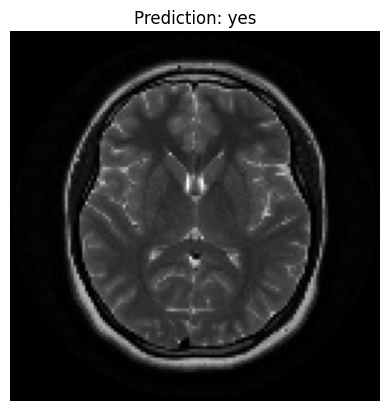

In [ ]:
import matplotlib.pyplot as plt

def predict_xray(image_path, model, scaler):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (128, 128))
    eq = cv2.equalizeHist(img_resized)

    features = np.array(extract_fft_features(eq)).reshape(1, -1)

    scaled = scaler.transform(features)

    prediction = model.predict(scaled)

    plt.imshow(img_resized, cmap='gray')
    plt.title(f"Prediction: {prediction[0]}")
    plt.axis("off")
    plt.show()

    return prediction[0]

image_path = "/content/dataset/no/1 no.jpeg"
result = predict_xray(image_path, best_model, scaler)


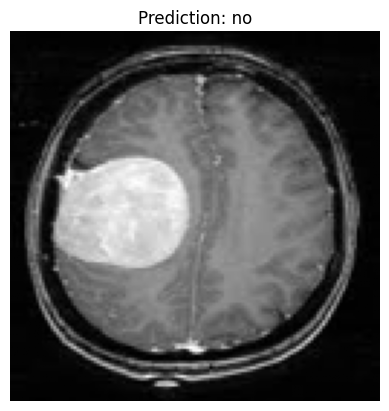


🧪 Prediction for the new image: no


In [ ]:
image_path_2 = "/content/dataset/yes/Y1.jpg"

result_2 = predict_xray(image_path_2, best_model, scaler)

print(f"\n🧪 Prediction for the new image: {result_2}")


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


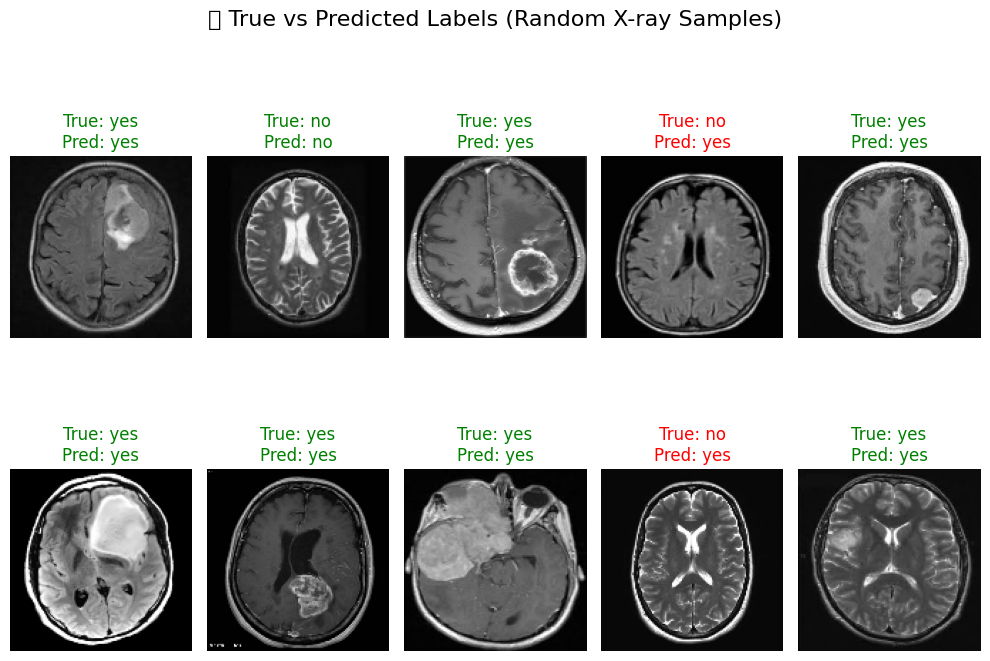

In [ ]:
import random
from glob import glob

def random_predictions_from_test_set(test_dir, model, scaler, n=12):
    normal_images = glob(os.path.join(test_dir, "no", "*.jpg"))
    pneumonia_images = glob(os.path.join(test_dir, "yes", "*.jpg"))
    all_images = normal_images + pneumonia_images

    n = min(n, len(all_images))
    if n == 0:
        print("Error: No images found in the test directory.")
        return

    sampled_images = random.sample(all_images, n)


    plt.figure(figsize=(10, 10))

    for i, image_path in enumerate(sampled_images):
        true_label = "yes" if "yes" in image_path else "no"

        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (128, 128))
        eq = cv2.equalizeHist(img_resized)

        features = np.array(extract_fft_features(eq)).reshape(1, -1)
        scaled = scaler.transform(features)

        prediction = model.predict(scaled)[0]

        plt.subplot(3, 5, i + 1)
        plt.imshow(img_resized, cmap="gray")
        plt.title(f"True: {true_label}\nPred: {prediction}", color=("green" if prediction == true_label else "red"))
        plt.axis("off")

    plt.tight_layout()
    plt.suptitle("✅ True vs Predicted Labels (Random X-ray Samples)", fontsize=16, y=1.05)
    plt.show()

test_dir = "/content/dataset"
random_predictions_from_test_set(test_dir, best_model, scaler, n=10)